In [44]:
%matplotlib widget


import meshplot as mp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import torch

In [45]:
### Havercamp model parameters and initial condition & boundary conditions ###

alpha = 1.611*(10**6)
theta_s = 0.287
theta_r = 0.075
beta = 3.96
k_s = 0.00944
A = 1.175*(10**6)
gamma = 4.74

def compute_phi(h):
    return (alpha*(theta_s-theta_r))/(alpha + torch.abs(h)**beta) + theta_r

def compute_k(h):
    return (k_s * A)/(A + torch.abs(h)**gamma)

def compute_c(h):
    return (alpha*(theta_s - theta_r)*beta*(torch.abs(h)**(beta-1)))/((alpha+torch.abs(h)**beta)**2)
    #compute_phi(h).backward(torch.ones_like(h))
    #return h.grad



h_top = -20.7
h_bottom = -61.5
h_initial = -61.5

In [46]:
### Grid setup ###

# Boundary points
xFirst = 0
xLast = 40

# Spatial discretization
N = 40
dx = (xLast-xFirst)/N

x = torch.zeros(N+1)
for i in range(0,N+1):
    x[i] = xFirst + i*dx
#x.requires_grad = True


In [47]:
### Defining matrix and source vector for solving linear system ###

def mat_and_r(C,K,phi,phi_last_time,H,dt,dx):
    N = H.size(0)-1
    mat = torch.zeros((N+1,N+1))
    mat[0,0] = 1
    mat[N,N] = 1

    for i in range(1,N):
        mat[i,i] = C[i]/dt + (K[i]+K[i]+K[i-1]+K[i+1])/(2*dx*dx)
        mat[i,i-1] = -(K[i]+K[i-1])/(2*dx*dx)
        mat[i,i+1] = -(K[i]+K[i+1])/(2*dx*dx)
    
    r = torch.zeros(N+1)
    for i in range(1,N):
        r[i] = ((K[i]+K[i+1])*(H[i+1]-H[i]) - (K[i]+K[i-1])*(H[i]-H[i-1]))/(2*dx*dx) + (K[i+1]-K[i-1])/(2*dx) - (phi[i]-phi_last_time[i])/dt
    
    #r = r.flip(dims=[0])

    return mat,r

In [48]:
### Update scheme ###


def h_from_delta(delta,h_m):
    H = torch.zeros(h_m.size(0))
    for i in range(1,h_m.size(0)):
        H[i] = delta[i] + h_m[i]
    H[0] = h_top
    H[-1] = h_bottom
    return H

def iteration_scheme(h_m,phi_last_time,num_iterations,dt,dx):
    for iterations in range(num_iterations):
        phi_m,c_m,k_m = compute_phi(h_m),compute_c(h_m),compute_k(h_m)
        mat,r = mat_and_r(c_m,k_m,phi_m,phi_last_time,h_m,dt,dx)
        #print(iterations,"\n\n",phi_m)
        delta = torch.linalg.solve(mat,r)
        #print(iterations,"\n\n",delta)
        h_m_next = h_from_delta(delta,h_m)
        #print(iterations,"\n\n",h_m_next)
        h_m = h_m_next.detach()
        h_m.requires_grad = True

    return h_m_next


def mpfd_solver(h0,num_iterations,T,dt,dx):
    h_last_time = h0
    phi_last_time = compute_phi(h0)
    t = 0.0

    result=[]
    result.append(h_last_time)

    while(t<T):
        h_next_time = iteration_scheme(h_last_time,phi_last_time,num_iterations,dt,dx)
        h_last_time = h_next_time.detach()
        h_last_time.requires_grad = True
        phi_last_time = compute_phi(h_last_time)
        t = t+dt
        result.append(h_last_time)
        #print(t,"\n",h_last_time)
    
    return result

In [55]:
h0 = h_initial * torch.ones(N+1)
h0[0] = -20.7
h0.requires_grad = True
c0,phi0,k0 = compute_c(h0),compute_phi(h0),compute_k(h0)


test = mpfd_solver(h0,20,360,30,dx)[-1]





#test2 = mpfd_solver(h0,20,360,30)
#print(test2)
#test3 = mpfd_solver(h0,20,360,10)
#print(test3)




In [50]:
### Mass-balance formula ###


def mass_balance():

    return None

In [51]:
### Plotting environment ###
xFinal = x.detach().numpy()
hFinal = test[-1].detach().numpy()
#hFinal2 = test2.detach().numpy()
#hFinal3 = test3.detach().numpy()

plt.figure(figsize=(10, 6))  # Optional: Specifies the figure size
plt.plot(xFinal, hFinal,color='blue')
#plt.plot(xFinal, hFinal2,color='red')
#plt.plot(xFinal, hFinal3,color='green')


plt.grid(True)

NameError: name 'test' is not defined

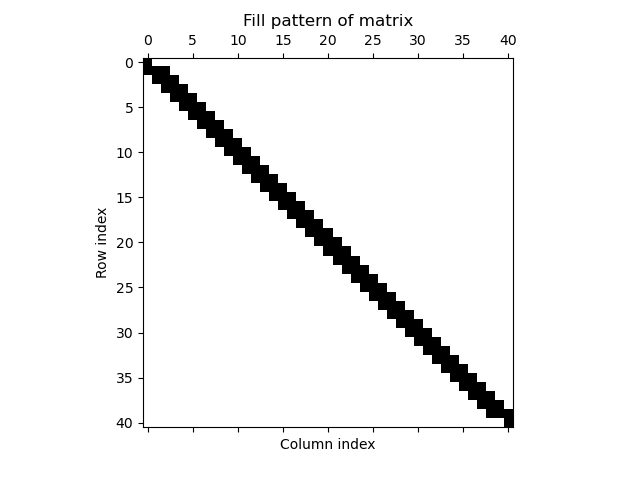

In [ ]:
M,R = mat_and_r(c0,k0,phi0,phi0,h0,120,dx)


fig = plt.figure()
ax = plt.subplot(111)
plt.spy(M.detach().numpy());
ax.set_title('Fill pattern of matrix');
ax.set_ylabel('Row index');
ax.set_xlabel('Column index');
plt.show()


In [ ]:
### ###
